三叉树基本框架：
![tritree](../note_pic/v2-b35fa06627a584aae8944665be060810_r.jpeg)
需要考虑到几个因素：
1. 资产价格(图例股票价格)的上升, 下降或保持不变是遵循 BS 过程。就是几何布朗运动(geometric Brownian motion) :
$d S=(r-d i v) S d t+\sigma S d z$. 由于我们这回要考虑一个带有dividend yield的情况, 所以公式有些变化
2. 同时, 为了得到在 $0 \sim T$ 时间段每一个 $d t$, 我们假设共有 $N$ 个区间, 那么 $d t=T / N$
3. 当然也通常要取这个积分的自然对数形式来得到更简单的形式; 如果想得到每一个小区间的价格变化 $d x$, 可以用通过 $d x=\sigma \sqrt{3 \cdot d t}$ 来得到。最终, 股票价格的向上移动为 $e^{d x}$ , 向下移动为 $e^{-d x}$, 而当中的(三叉树的中间)则为 $S_{0}$, 也就是初始价格。
做这些的目的, 都是为了得出最后需要的股价运动的概率:
$$
\begin{aligned}
&p_{u}=\frac{1}{2} d t \cdot\left((\sigma / d x)^{2}+\nu / d x\right) \\
&p_{m}=1-d t \cdot(\sigma / d x)^{2}-r \cdot d t
\end{aligned}
$$
$$p_{d}=\frac{1}{2} d t \cdot\left((\sigma / d x)^{2}-\nu / d x\right)$$,
其中, $p_{u}$ 为向上运动的概率, $p_{m}$ 为不变的概率, $p_{d}$ 为向 下运动的概率, $\nu=r-d i v-\frac{1}{2} \sigma^{2}$ 。当然这个也很容易实现:

In [13]:
import numpy as np
from py_vollib_vectorized import vectorized_black_scholes_merton
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
S0=100
T=1
r=0.06
K=100
sigma=0.2
div = 0.03
vectorized_black_scholes_merton('c',S0,K,T,r,sigma,div,return_as='array')[0]

9.135195269350582

In [5]:
def call_payoff(strike, S_array):
    # 首先建立一个看涨期权payoff的function
    length_of_S_array= len(S_array)
    strike_array=strike*np.ones(length_of_S_array)
    # 目的是要返回一个max(S-K,0)的值
    values=np.maximum(S_array-strike_array,0)
    return values

def step_back_tree(pu,pm,pd, values,n):
    # 在建立一个三叉树的模型
    # n 为我们想要多少步三叉树
    # n=1 则为我们从最终点向前推的第一步
    # n=N 的时候，也就到达了我们树模型的最初点，也就是期权的价格

    # 看看我们的最终点有多少个值
    length = len(values)

    # 准备好一个空的向量来存放我们计算过后的期权价值
    option_values = np.zeros(length)

    # 向前推导，只留下中间的值，前后n个值保存为0
    option_values[n:length-n] = pu*values[n+1:length-n+1] + pm*values[n:length-n] + pd*values[n-1:length-n-1]

    return option_values

def set_parameters(S_0, T, r, sigma, div, N):

    # 这就是我们刚刚计算上下概率的函数
    dt = T/N
    dx = sigma*np.sqrt( 3*dt )
    nu = r- div- 0.5 * sigma**2

    pu = (1/2)*dt* ( (sigma/dx)**2 + nu/dx )
    pm = 1 - dt*(sigma/dx)**2 - r*dt
    pd = (1/2) * dt * ( (sigma/dx)**2 - nu/dx )

    S_array = S_0 * np.exp(dx * np.linspace(-N,N, 2*N+1))

    return pu, pm, pd, S_array

def European_call_option(S_0, T, r, sigma, div, N, strike):
    # 计算模拟后的树模型（主要）

    # 首先得到我们需要的概率
    pu, pm, pd, S_array = set_parameters(S_0, T, r, sigma, div, N)

    # 得到我们最终输出的payoff
    values= call_payoff(strike, S_array)

    # 用一个for循环来得到每一次先前推导而得到的价格，并且将新的价格保存在values中
    for n in range(1,N+1):
        intermediate_option_prices=step_back_tree(pu,pm,pd, values,n)
        values = intermediate_option_prices
    # 这个向量中间的值，也就是我们树模型的根，期权的价格！
    return values[N]

# 模拟一万步的树模型
N=10000
# 同样的参数
S0=100
T=1
r=0.06
K=100
sigma=0.2
div = 0.03

tree_approx= European_call_option(S0, T, r, sigma, div, N, K)
print(tree_approx)

9.13503774551553


In [11]:
def approximation(S_0, T, r, sigma, div, N, strike):

    approx_error = (vectorized_black_scholes_merton('c',S0,K,T,r,sigma,div,return_as='array')[0]
                  -European_call_option(S0, T, r, sigma, div, N, K))/vectorized_black_scholes_merton('c',S0,K,T,r,sigma,div,return_as='array')[0]

    return approx_error

# 我们计算下 N = 10000 步时候的误差
approximation(S_0=S0, T=T, r=r, sigma=sigma, div=div, N=10000, strike=K)

1.7243619912540633e-05

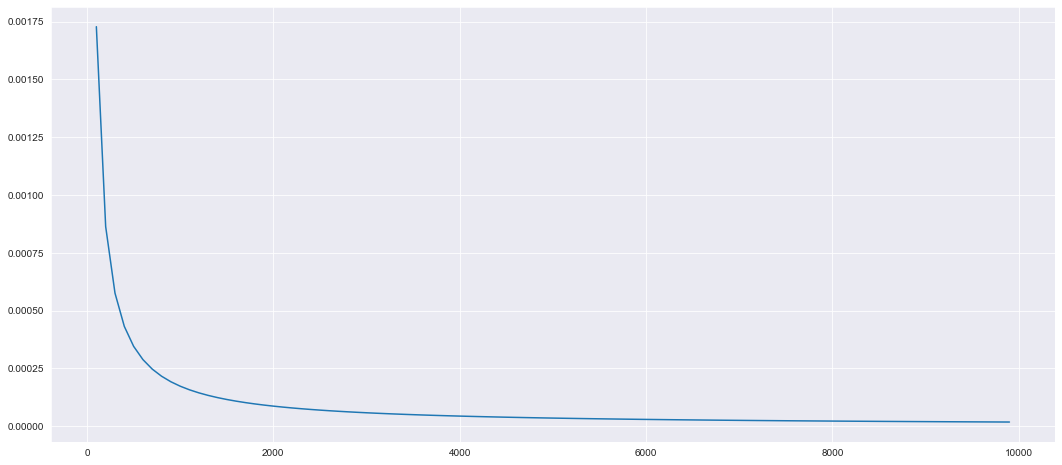

In [21]:
N=np.arange(100,10000,100)
error = []
for i in N:
    error.append(approximation(S_0=S0, T=T, r=r, sigma=sigma, div=div, N=i, strike=K))

fig = plt.figure(figsize=(18,8))
plt.plot(N,error)
plt.show()